In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
from scipy import stats as stats




In [2]:
#reading data and preprocessing

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

train_b.to_csv('raw_b.csv')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

class model():
    
    def __init__(self) -> None:


        self.average_measurement_a = {}
        self.average_measurement_b = {}
        self.average_measurement_c = {}
        self.elevation_mapping = {
            6.0 : -1,
            7.0 : 0,
            24.0 : 1
        }


    def add_estimated_flag(self, df, estimated):
        data = df.copy()

        data['estimated'] = 1 if estimated else 0

        return data

    def feature_engineering(self, df):
        data = df.copy()

        #specifying features to drop based on low correlation or qualitative measures
        #NOTE: wind vector v is kept instead of absolute value due to high correlation across locations
        drop = ['fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'precip_5min:mm', 'precip_type_5min:idx', 'rain_water:kgm2', 'snow_density:kgm3', 'snow_drift:idx', 'snow_melt_10min:mm', 'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms', 'wind_speed_10m:ms', 'ceiling_height_agl:m']

        #dropping specified features
        for feat in drop:
            if feat in data.columns:
                data.drop(columns=feat, axis=1, inplace=True)

        
        return data        

    def preprocessing_X_train(self, df):
        data = df.copy()
        #data = self.feature_engineering(data)
        if 'date_calc' in data.columns:
            data.drop('date_calc', axis=1, inplace=True)
        
        if 'date_forecast' in data.columns:
            data['hour'] = data['date_forecast'].dt.hour
            data['week'] = pd.to_numeric(data['date_forecast'].dt.isocalendar().week)
            data['month'] = data['date_forecast'].dt.month
            data['week_hour'] = data['week'] * 100 + data['hour']
            data.set_index('date_forecast', inplace=True)

        data = data.groupby(pd.Grouper(freq='1H')).mean()
        data.dropna(how='all', inplace=True)

        #data = data.interpolate(method='time')

        data['loc_flag'] = data['elevation:m'].map(self.elevation_mapping)
        data.drop(columns=['elevation:m'], inplace=True)

        data.rename_axis('time', inplace=True)
        
        return data
    
    def preprocessing_X_train_combo(self, df):
        data = df.copy()
        # Loop through unique loc_flag values (-1, 0, 1)
        for loc_flag in data['loc_flag'].unique():
            # Filter the DataFrame for the current loc_flag value
            filtered_df = data[data['loc_flag'] == loc_flag]
            
            # Group the filtered DataFrame by 'month' and calculate the mean 'pv_measurement'
            avg_measurement_by_month = filtered_df.groupby('week_hour')['pv_measurement'].mean()
            
            # Convert the result to a dictionary
            avg_measurement_dict = avg_measurement_by_month.to_dict()
            
            # Assign the result to the appropriate dictionary based on loc_flag value
            if loc_flag == -1:
                self.average_measurement_a = avg_measurement_dict
            elif loc_flag == 0:
                self.average_measurement_b = avg_measurement_dict
            elif loc_flag == 1:
                self.average_measurement_c = avg_measurement_dict
                
        data['average_measurement'] = data.apply(lambda row: self.average_measurement_a[row['week_hour']]
                                             if row['loc_flag'] == -1
                                             else (self.average_measurement_b[row['week_hour']]
                                                   if row['loc_flag'] == 0
                                                   else self.average_measurement_c[row['week_hour']]), axis=1)
        data.drop(columns='week_hour', axis=1, inplace=True)
        data = data.sample(frac=1, random_state=42).reset_index(drop=True)

        
        return data



    def preprocessing_X_test(self, df):
        data = df.copy()
        if 'date_calc' in data.columns:
            data.drop('date_calc', axis=1, inplace=True)

        #data = self.feature_engineering(data)

        if 'date_forecast' in data.columns:
            data['hour'] = data['date_forecast'].dt.hour
            data['week'] = pd.to_numeric(data['date_forecast'].dt.isocalendar().week)
            data['month'] = data['date_forecast'].dt.month
            data['week_hour'] = data['week'] * 100 + data['hour']
            data.set_index('date_forecast', inplace=True)
            

        data = data.groupby(pd.Grouper(freq='1H')).mean()
        data.dropna(how='all', inplace=True)
        

        data['loc_flag'] = data['elevation:m'].map(self.elevation_mapping)
        data.drop(columns=['elevation:m'], inplace=True)

        data['average_measurement'] = data.apply(lambda row: self.average_measurement_a[row['week_hour']]
                                             if row['loc_flag'] == -1
                                             else (self.average_measurement_b[row['week_hour']]
                                                   if row['loc_flag'] == 0
                                                   else self.average_measurement_c[row['week_hour']]), axis=1)
        
        data.drop(columns='week_hour', axis=1, inplace=True)
        data.rename_axis('time', inplace=True)
        
        return data

    def preprocessing_Y(self, data, summer=False):
        if 'time' in data.columns:
            data.set_index('time', inplace=True)
        data.dropna(inplace=True)

        # Create a mask to identify sequences of 18 or more consecutive rows with the same 'pv_measurement'
        consecutive_mask = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] != 0)
        consecutive_count = consecutive_mask.groupby((~consecutive_mask).cumsum()).cumsum()
        mask_consecutive = (consecutive_count <= 3) | (~consecutive_mask)

        consecutive_mask_0 = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] == 0)
        consecutive_count_0 = consecutive_mask_0.groupby((~consecutive_mask_0).cumsum()).cumsum()
        mask_consecutive_0 = (consecutive_count_0 <= 96) | (~consecutive_mask_0)

        
        if summer:
            # Filter rows for the specified months (April, May, June, July)
            mask_time = data.index.month.isin([4, 5, 6, 7])
            # Combine the consecutive rows mask and the time mask
            combined_mask = mask_consecutive & mask_consecutive_0 & mask_time
        else:
            combined_mask = mask_consecutive & mask_consecutive_0

        filtered_data = data[combined_mask]

        return filtered_data


model_basic = model()
model_estimated = model()
model_observed = model()
model_summer =model()

#adding estimated flags
observed_a = model_basic.add_estimated_flag(X_train_observed_a, False)
estimated_a = model_basic.add_estimated_flag(X_train_estimated_a, True)


#creating location specific models
x_train_a_concat = pd.concat([observed_a, estimated_a], axis=0)
x_train_a_pre = model_basic.preprocessing_X_train(x_train_a_concat)
y_train_a = model_basic.preprocessing_Y(train_a)
x_train_a_merge = x_train_a_pre.merge(y_train_a, how='inner', on='time')
x_train_a = model_basic.preprocessing_X_train_combo(x_train_a_merge)

#x_train_a.to_csv('proc_training_data_a.csv')

observed_b = model_basic.add_estimated_flag(X_train_observed_b, False)
estimated_b = model_basic.add_estimated_flag(X_train_estimated_b, True)

x_train_b_concat = pd.concat([observed_b, estimated_b], axis=0)
x_train_b_pre = model_basic.preprocessing_X_train(x_train_b_concat)
y_train_b = model_basic.preprocessing_Y(train_b)
x_train_b_merge = x_train_b_pre.merge(y_train_b, how='inner', on='time')
x_train_b = model_basic.preprocessing_X_train_combo(x_train_b_merge)

#x_train_b.to_csv('proc_training_data_b.csv')


observed_c = model_basic.add_estimated_flag(X_train_observed_c, False)
estimated_c = model_basic.add_estimated_flag(X_train_estimated_c, True)

x_train_c_concat = pd.concat([observed_c, estimated_c], axis=0)
x_train_c_pre = model_basic.preprocessing_X_train(x_train_c_concat)
y_train_c = model_basic.preprocessing_Y(train_c)
x_train_c_merge = x_train_c_pre.merge(y_train_c, how='inner', on='time')
x_train_c = model_basic.preprocessing_X_train_combo(x_train_c_merge)

#x_train_c.to_csv('proc_training_data_c.csv')

#dataset with all data across all loactions
x_train = pd.concat([x_train_a, x_train_b, x_train_c], axis=0, ignore_index=True)
x_train = x_train.sample(frac=1, random_state=42).reset_index(drop=True)


#datasets with estimated data per location
x_train_a_estimated_pre = model_estimated.preprocessing_X_train(estimated_a)
x_train_a_estimated_merge = x_train_a_estimated_pre.merge(y_train_a, how='inner', on='time')
x_train_a_estimated = model_estimated.preprocessing_X_train_combo(x_train_a_estimated_merge)

x_train_b_estimated_pre = model_estimated.preprocessing_X_train(estimated_b)
x_train_b_estimated_merge = x_train_b_estimated_pre.merge(y_train_b, how='inner', on='time')
x_train_b_estimated = model_estimated.preprocessing_X_train_combo(x_train_b_estimated_merge)

x_train_c_estimated_pre = model_estimated.preprocessing_X_train(estimated_c)
x_train_c_estimated_merge = x_train_c_estimated_pre.merge(y_train_c, how='inner', on='time')
x_train_c_estimated = model_estimated.preprocessing_X_train_combo(x_train_c_estimated_merge)


#datasets with observed data per location
x_train_a_observed_pre = model_observed.preprocessing_X_train(observed_a)
x_train_a_observed_merge = x_train_a_observed_pre.merge(y_train_a, how='inner', on='time')
x_train_a_observed = model_observed.preprocessing_X_train_combo(x_train_a_observed_merge)

x_train_b_observed_pre = model_observed.preprocessing_X_train(observed_b)
x_train_b_observed_merge = x_train_b_observed_pre.merge(y_train_b, how='inner', on='time')
x_train_b_observed = model_observed.preprocessing_X_train_combo(x_train_b_observed_merge)

x_train_c_observed_pre = model_observed.preprocessing_X_train(observed_c)
x_train_c_observed_merge = x_train_c_observed_pre.merge(y_train_c, how='inner', on='time')
x_train_c_observed = model_observed.preprocessing_X_train_combo(x_train_c_observed_merge)


#dataset with summer data accross all locations
y_train_a_summer = model_summer.preprocessing_Y(train_a, summer=True)
x_train_a_summer_merge = x_train_a_pre.merge(y_train_a_summer, how='inner', on='time')
x_train_a_summer = model_summer.preprocessing_X_train_combo(x_train_a_summer_merge)

y_train_b_summer = model_summer.preprocessing_Y(train_b, summer=True)
x_train_b_summer_merge = x_train_a_pre.merge(y_train_b_summer, how='inner', on='time')
x_train_b_summer = model_summer.preprocessing_X_train_combo(x_train_b_summer_merge)

y_train_c_summer = model_summer.preprocessing_Y(train_c, summer=True)
x_train_c_summer_merge = x_train_a_pre.merge(y_train_c_summer, how='inner', on='time')
x_train_c_summer = model_summer.preprocessing_X_train_combo(x_train_c_summer_merge)

x_train_summer = pd.concat([x_train_a_summer, x_train_b_summer, x_train_c_summer], axis=0, ignore_index=True)
x_train_summer = x_train_summer.sample(frac=1, random_state=42).reset_index(drop=True)





checkframe = x_train_a

def corr():
    bad_variables= ['week']

    for col in [col for col in checkframe.columns if col not in bad_variables]:

        corr = checkframe[col].corr(checkframe['pv_measurement'])
        print(f"Correlation between {col} and pv_measurement is: {corr}")




y_train_a_summer.head(2000)


,pv_measurement
time,
2019-06-02 22:00:00,0.00
2019-06-02 23:00:00,0.00
2019-06-03 00:00:00,0.00
2019-06-03 01:00:00,0.00
2019-06-03 02:00:00,19.36
...,...
2020-04-25 01:00:00,0.00
2020-04-25 02:00:00,0.00
2020-04-25 03:00:00,2.86


Checkpoint 2
Checkpoint 3


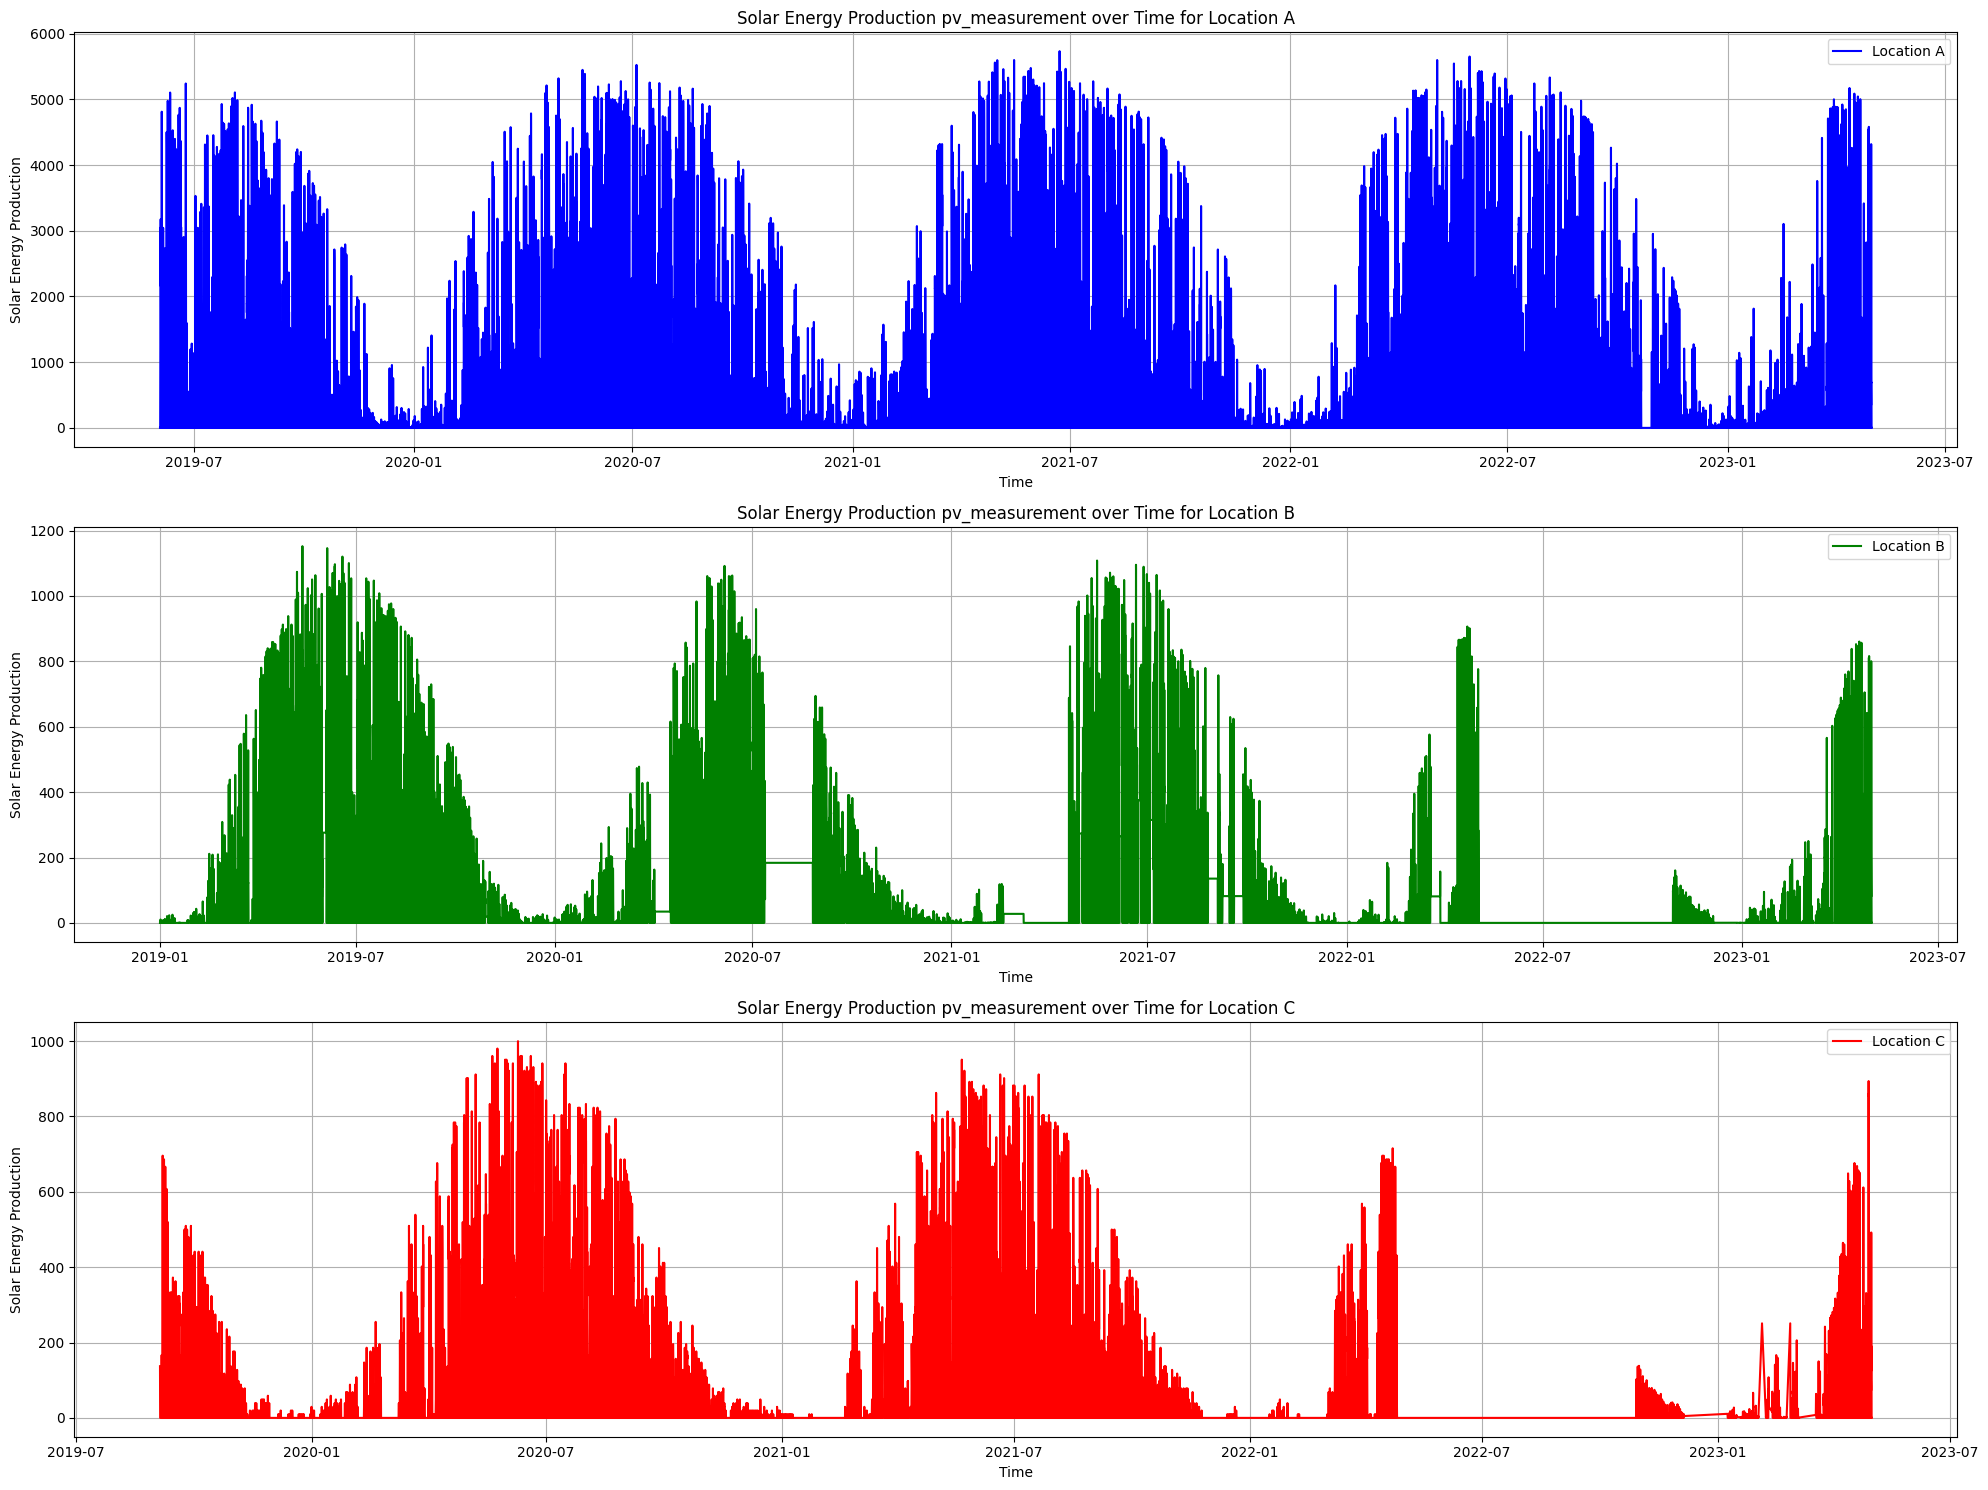

In [69]:
#exploratory data analysis and vizualization 
%matplotlib inline

data_a = train_a
data_b = train_b
data_c = train_c

columns = data_a.columns.to_list()

el = 'pv_measurement'


# Plotting the pv_measurement over time for locations A, B, and C
print('Checkpoint 2')
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(data_a[el], label='Location A', color='blue')
plt.title(f'Solar Energy Production {el} over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

print('Checkpoint 3')

# Location B
plt.subplot(3, 1, 2)
plt.plot(data_b[el], label='Location B', color='green')
plt.title(f'Solar Energy Production {el} over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(data_c[el], label='Location C', color='red')
plt.title(f'Solar Energy Production {el} over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)



plt.tight_layout()

plt.show()




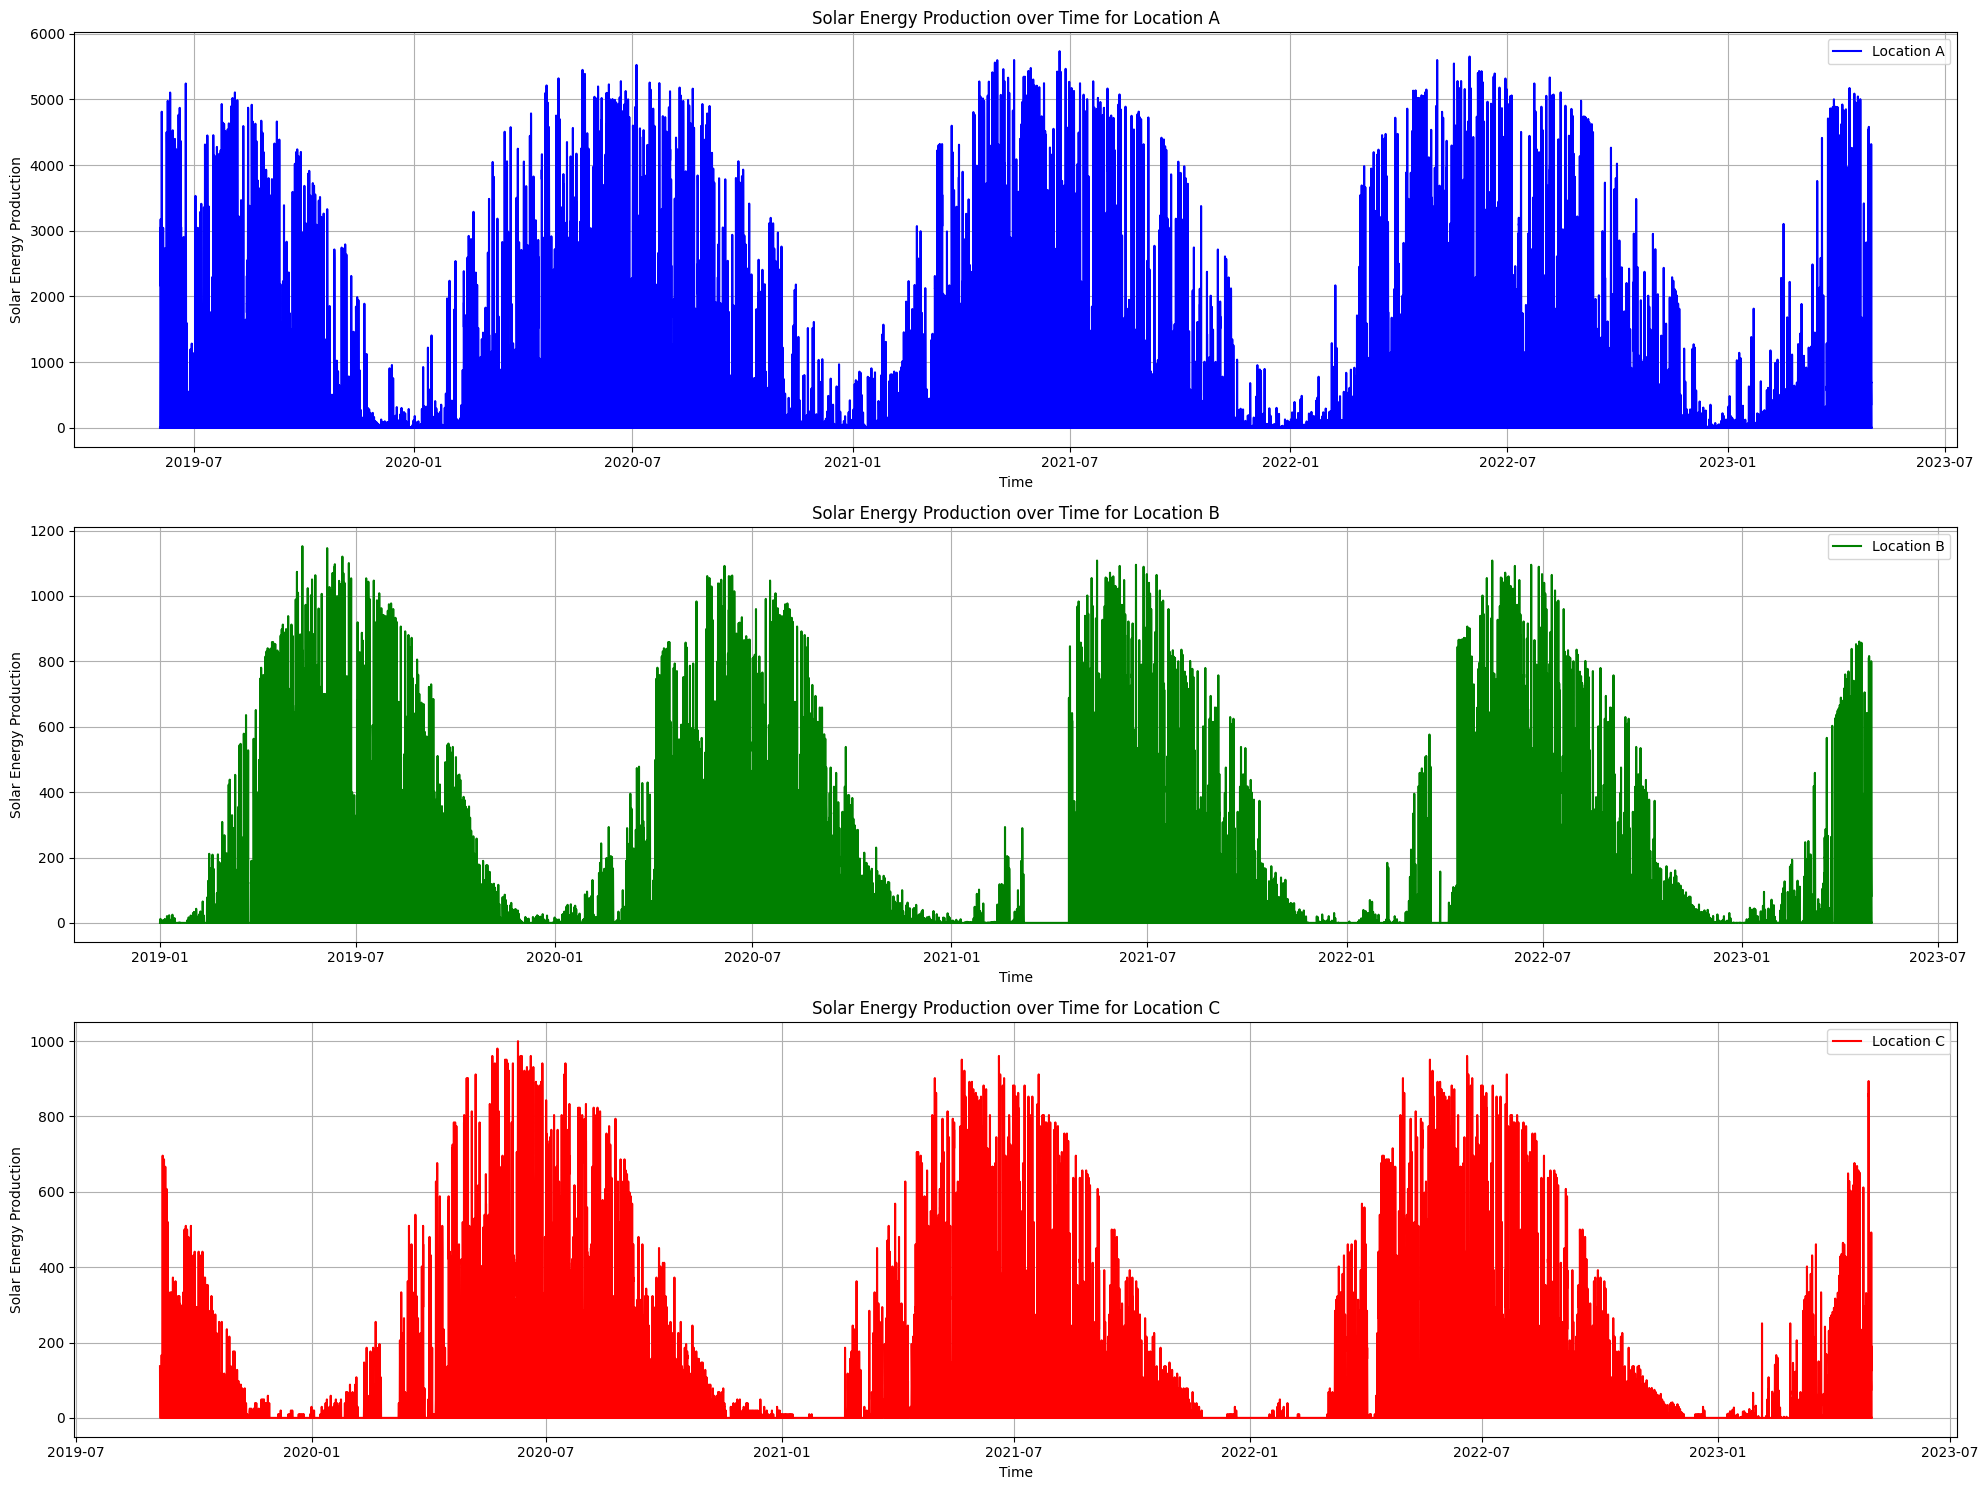

In [4]:
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(x_train_a['pv_measurement'], label='Location A', color='blue')
plt.title(f'Solar Energy Production over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location B
plt.subplot(3, 1, 2)
plt.plot(x_train_b['pv_measurement'], label='Location B', color='green')
plt.title(f'Solar Energy Production over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(x_train_c['pv_measurement'], label='Location C', color='red')
plt.title(f'Solar Energy Production over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
#AutoML H2O

def train(train_df, val_df, model_type):


    h2o.init()
    train = h2o.H2OFrame(train_df)
    train.describe()

    val = h2o.H2OFrame(val_df)

    x = train.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    from h2o.automl import H2OAutoML
    # callh20automl  function
    aml = H2OAutoML(max_runtime_secs=120,
                    sort_metric='MAE'
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = train, validation_frame=val)

    leaderboard = aml.leaderboard
    best_model = aml.leader

    # Obtain the leader model
    #best_model_1 = h2o.get_model(leaderboard[0, 'model_id'])
    #best_model_2 = h2o.get_model(leaderboard[1, 'model_id'])
    #best_model_3 = h2o.get_model(leaderboard[2, 'model_id'])


    # Save the leader model
    #model_path_1 = h2o.save_model(model=best_model_1, path="/tmp/mymodel", force=True)
    #model_path_2 = h2o.save_model(model=best_model_2, path="/tmp/mymodel", force=True)
    #model_path_3 = h2o.save_model(model=best_model_3, path="/tmp/mymodel", force=True)

    # Load the saved model
    #loaded_model_1 = h2o.load_model(model_path_1)
    #loaded_model_2 = h2o.load_model(model_path_2)
    #loaded_model_3 = h2o.load_model(model_path_3)

    # Download the model to local machine
    #my_local_model_1 = h2o.download_model(best_model_1, path=f"./models/{model_type.upper()}")
    #my_local_model_2 = h2o.download_model(best_model_2, path=f"./models/{model.upper()}")
    #my_local_model_3 = h2o.download_model(best_model_3, path=f"./models/{model.upper()}")

    model_path = h2o.save_model(model=best_model, path="/tmp/mymodel", force=True)
    loaded_model = h2o.load_model(model_path)
    my_local_model = h2o.download_model(best_model, path=f"./models/{model_type.upper()}")

    h2o.cluster().shutdown()

    return my_local_model #my_local_model_1, my_local_model_2, my_local_model_3 

 

In [10]:
model_a_observed = train(x_train_a_observed, x_train_a_estimated, 'a')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 00 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_olelasson_psfvnm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.447 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:29667
Cols:51

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,0.699999988079071,1.1449999809265137,27.849998474121097,0.0,0.0,27.899999618530273,-1.0,251.0749969482422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.4000244140624,0.0,0.0,932.4000244140624,938.2000122070312,0.0,0.0,22.700000762939453,944.0,,0.0,0.0,0.0,0.0,6.982999801635742,-49.89399719238281,0.0,259.0,0.0,159.6750030517578,0.02500000037252903,-7.224999904632568,-8.399999618530273,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
mean,6.652589578816513,1.249063605766677,2931.676805693993,599406.7312298383,166.50181767468683,1749.0912095915146,0.022398624734553525,276.8233811218421,44.9186579364477,161707.031716638,56.61221309148384,203804.1766561064,67.60606654264049,0.053117942439953075,0.004418208816166243,0.10624346916184618,0.01327737893983428,0.02656739809202421,0.5213958270131781,0.51164593656251,1009.6328242577081,0.006301614571481772,0.09101864023999734,996.7653243174523,1002.8681943980026,0.1874001415910822,0.011913911283614421,74.23161002893418,1008.9981873688076,,0.05276317153462907,0.0,6.168469924833957e-05,0.09156638769466256,179.63072649747158,1.5298389892145035,0.05908753942685305,280.7086223353234,74.40169973342412,32446.955286229768,3.043210468659349,0.7567962718759045,0.5174326687262257,1.9381804987635005e-05,0.0,11.500353928607543,27.29221019988545,6.675632858057766,-1.0,674.1455209492042,674.1455209492034
maxs,17.350000381469727,1.4262499809265137,12285.650390625,2988627.5,835.0999755859375,11673.625,1.0,293.625,332.2749938964844,1191085.25,683.4000244140625,2441749.5,100.0,15.0,3.549999952316284,15.0,7.875,14.225000381469728,1.0,1.0,1043.949951171875,0.6225000023841858,3.75,1030.875,1037.25,82.3499984741211,1.100000023841858,100.0,1043.7249755859375,,6.300000190734863,0.0,0.119999997317791,5.650000095367432,348.48651123046875,49.90550231933594,1.2999999523162842,303.25,100.0,69395.5234375,13.274999618530272,11.199999809265137,8.25,0.10000000149011612,0.0,23.0,53.0,12.0,-1.0,5733.42,3812.7676190476186
sigma,2.795389090967754,0.03630398252168923,2571.6683392394043,877458.9549459427,244.36002508893654,1818.6367523489146,0.1809979782036157,6.700174794936154,64.51840413817446,229471.18967374795,119.19661253745562,423268.617820725,33.58517056493492,0.4869102614749427,0.07026779857501854,0.7429262108921122,0.1776780086164894,0.30295042419220697,0.4857004822913581,0.4878340682036288,12.48415407988059,0.031464244340478155,0.3191490962615663,12.350161371461711,12.40416305974516,2.4852029524817176,0.046237827582230044,13.8551510783274,12.460261148573748,,0.4093491373782911,0.0,0.0018524375240954228,0.24422800947289297,98.16804925818474,24.108603523010256,0.10667150248515177,6.572128600438952,33.17469676930491,17827.723537031376,1.7725401604163828,2.8505839422441395,1.8426605200957755,0.0012399920515587352,0.0,6.9228656232855466,14.478011500965373,3.306912603910368,0.0,1195.5317244979797,999.411693960943
zeros,0,0,0,11994,13236,0,28376

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
09:28:14.662: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
09:28:14.810: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

█████████████
09:28:41.58: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

██
09:28:44.480: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

███████████
09:29:05.771: _train param, Dropping unused columns: [estimated, snow_drift:idx, loc_flag]

██
09:29:08.295: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

█████
09:29:18.174: _train param, Dropping bad and constant columns: [estimated, sn

In [11]:
model_b_observed = train(x_train_b_observed, x_train_b_estimated, 'b')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpbjvtgk5h
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpbjvtgk5h/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpbjvtgk5h/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_olelasson_yvvo65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:24655
Cols:51

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,0.699999988079071,1.1514999866485596,27.849998474121097,0.0,0.0,27.975000381469727,-1.0,251.0500030517578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.5,0.0,0.0,932.2999877929688,938.0499877929688,0.0,0.0,19.575000762939453,943.8499755859376,,0.0,0.0,0.0,0.0,6.983749866485596,-49.89324951171875,0.0,259.0249938964844,0.0,270.0,0.05000000074505806,-7.224999904632568,-7.599999904632568,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
mean,6.018708172194555,1.2546337454924839,2612.5295444308285,524305.3564284631,145.59152001240247,1767.2202521338847,0.007980125735144996,275.27815651213695,39.618364424996656,142668.64765479314,53.28349116875113,191884.63050162545,66.14183330949457,0.08199858036858508,0.006812005726833222,0.16309977675748638,0.020459338858243147,0.04096836334242101,0.48582437639424036,0.5492293652403176,1009.0160545260926,0.005606773463584963,0.08130196714662338,995.9803772430633,1002.1081921359495,0.04730582015373189,0.009172581784658337,73.06326909557431,1008.2632630520914,,0.3476850543208943,8.111944838775097e-05,0.00032346379912783787,0.08875583126057618,179.6227546058497,-1.0908244237747973,0.056267492408531586,279.5057441818191,73.082780382398,33840.01673352393,3.0912086792420155,0.6123544920262312,0.5624274987801446,3.244777991415835e-05,0.0,11.505171364834709,25.39330764550799,6.231149868180887,0.0,105.53697627256147,105.53697627256155
maxs,17.350000381469727,1.4254999160766602,12285.775390625,2988610.25,835.0999755859375,11259.0,1.0,293.6000061035156,332.2749938964844,1129488.75,683.4000244140625,2441810.5,100.0,12.25,3.125,14.975000381469728,7.875,12.25,1.0,1.0,1042.14990234375,0.5849999785423279,3.0,1029.0,1035.2249755859375,51.900001525878906,0.8999999761581421,100.0,1041.4749755859375,,18.200000762939453,1.0,0.18000000715255737,3.325000047683716,348.4875183105469,49.90550231933594,1.2999999523162842,303.25,100.0,68500.0,13.274999618530272,11.199999809265137,7.800000190734863,0.10000000149011612,0.0,23.0,53.0,12.0,0.0,1152.3,836.6660714285714
sigma,2.6717624745443,0.03563800626417471,2357.52481331629,835532.9694108017,232.62718738871777,1690.9931590957985,0.10682999321908083,6.747868666321372,60.79485644072147,216413.44612687486,117.63439864908561,418323.37969848263,34.02912763016564,0.5825498238440028,0.07439138794790155,0.9833244930446562,0.19400626971708274,0.3404967874653381,0.4861353708059858,0.48534269391869866,13.064887549464498,0.028403047214255947,0.3211599559750858,12.947508807962656,13.00397302642591,0.9991703601501213,0.04025546712886969,14.463808090432712,13.062500819336833,,1.8888389682538826,0.008118229152032313,0.005090974421098715,0.2363590884425618,97.36429737695848,24.285960310269413,0.10428397784325155,6.659724128638815,33.79259737748652,17858.71274622224,1.7852357792437972,2.916369999812215,1.873312544747468,0.001623402660047217,0.0,6.917683701903808,15.720962480169348,3.5976773202050616,0.0,212.827168

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
09:30:35.937: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
09:30:36.29: _train param, Dropping bad and constant columns: [estimated, loc_flag]

█████████████
09:31:00.294: _train param, Dropping bad and constant columns: [estimated, loc_flag]

█
09:31:03.565: _train param, Dropping bad and constant columns: [estimated, loc_flag]

███████████
09:31:24.918: _train param, Dropping unused columns: [estimated, loc_flag]

█
09:31:26.978: _train param, Dropping bad and constant columns: [estimated, loc_flag]

██████
09:31:37.118: _train param, Dropping bad and constant columns: [estimated, loc_flag]

█████
09:31:47.473: _train param, Dropping bad and constant columns: [es

In [12]:
model_c_observed = train(x_train_c_observed, x_train_c_estimated, 'c')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpgf3cyznx
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpgf3cyznx/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpgf3cyznx/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_olelasson_g2jn9n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:20552
Cols:51

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,hour,week,month,loc_flag,pv_measurement,average_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,int,int,int,real,real
mins,1.2000000476837158,1.1392500400543213,28.399999618530273,0.0,0.0,28.575000762939453,-1.0,256.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.4500122070312,0.0,0.0,935.7000122070312,941.5499877929688,0.0,0.0,22.25,947.4000244140624,,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,264.8999938964844,0.0,292.625,0.10000000149011612,-6.275000095367432,-7.875,-0.10000000149011612,0.0,0.0,1.0,1.0,1.0,0.0,0.0
mean,6.242883907624524,1.2497102713981656,2923.3533225134183,540447.2438648264,150.1051697760584,1735.1337957965368,0.010777539898793296,276.00932526133715,40.33715942554681,145236.08658387547,52.99923726630614,190818.0138965347,67.26149160145631,0.15296808082255825,0.012908719354242074,0.30260193518661305,0.03872494166861944,0.07731242704561575,0.49781043207473796,0.5807828921759429,1009.6341901090913,0.005521238807862697,0.07089334371350722,994.1828350840764,1000.286199793179,1.8472837188708715,0.010085393329821283,74.40019342378687,1006.4165504220949,,0.03296637797815913,0.0,0.0003182172021944961,0.09484356842190474,179.6825370796,-0.19942730945582401,0.06521384894593024,280.28706316652756,74.01520656495337,32286.29903311933,2.867166212010935,0.8601279680316443,0.8470586791218389,8.150058546175677e-05,0.0,11.504038536395484,27.84624367458161,6.789996107434799,1.0,92.65320163487739,92.65320163487743
maxs,15.925000190734863,1.3619999885559082,12260.224609375,2990595.5,835.6500244140625,11652.7001953125,1.0,292.07501220703125,334.75,1198315.125,682.3250122070312,2437657.75,100.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1043.9000244140625,0.6075000166893005,3.0,1028.300048828125,1034.64990234375,96.7750015258789,0.699999988079071,100.0,1041.0999755859375,,6.599999904632568,0.0,0.17000000178813934,3.549999952316284,348.47698974609375,49.943748474121094,1.375,302.8999938964844,100.0,72160.703125,12.425000190734863,10.024999618530272,8.824999809265137,0.10000000149011612,0.0,23.0,53.0,12.0,1.0,999.6,778.4
sigma,2.5746355039161877,0.03396952406937449,2639.97070348995,829086.6390060763,230.9075068159213,1892.2776598483931,0.3516982838772686,6.159454190962316,60.59042584794127,215539.89251425138,115.8599186752147,411792.820601629,34.22621414037719,1.146017466699335,0.15367722131357123,1.7402706752824015,0.41152702481649533,0.7160455640042982,0.48625461804622355,0.4797651254575704,12.682419521501203,0.030445382607335928,0.30373715602289986,12.524235531885118,12.578241451520707,8.35775599105353,0.0426285713823898,14.599574811598933,12.634139246959903,,0.3309529150327442,0.0,0.004296141519703816,0.25048519208278586,97.55905124268043,23.76246953956232,0.11341809043284992,6.033885909479246,33.77432269582674,18354.70276594632,1.6539038977069136,2.3956682709459667,1.9299135784939636,0.011738432302780138,0.0,6.910853641108938,15.034387343150641,3.4331420120242213,0.0,179.16306829421674,159.726237842264


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
09:32:49.980: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
09:32:50.75: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

██████████████
09:33:16.984: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

█
09:33:20.194: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

███████████
09:33:40.668: _train param, Dropping unused columns: [estimated, snow_drift:idx, loc_flag]

█
09:33:42.540: _train param, Dropping bad and constant columns: [estimated, snow_drift:idx, loc_flag]

██████
09:33:52.643: _train param, Dropping bad and constant columns: [estimated, sn

In [36]:
weights = {0 : 1, 1 : 1, 2 : 1, 3 : 1, 4 : 1}
sum(weights.values())

5

In [46]:
models_a = [model_general, model_a, model_a_estimated, model_a_observed, model_summer]
models_b = [model_general, model_b, model_b_estimated, model_b_observed, model_summer]
models_c = [model_general, model_c, model_c_estimated, model_c_observed, model_summer]

print("Models for A:")
for model in models_a:
    print(model)

print("\nModels for B:")
for model in models_b:
    print(model)

print("\nModels for C:")
for model in models_c:
    print(model)

h2o.init()

x_test_a_general = model_basic.add_estimated_flag(X_test_estimated_a, True)
x_test_a_general = model_basic.preprocessing_X_test(x_test_a_general)
h2o_test_a_general = h2o.H2OFrame(x_test_a_general)
x_test_b_general = model_basic.add_estimated_flag(X_test_estimated_b, True)
x_test_b_general = model_basic.preprocessing_X_test(x_test_b_general)
h2o_test_b_general = h2o.H2OFrame(x_test_b_general)
x_test_c_general = model_basic.add_estimated_flag(X_test_estimated_c, True)
x_test_c_general = model_basic.preprocessing_X_test(x_test_c_general)
h2o_test_c_general = h2o.H2OFrame(x_test_c_general)



master_a_df = pd.DataFrame()
master_b_df = pd.DataFrame()
master_c_df = pd.DataFrame()





for i in range(len(models_a)):

    model_A = h2o.upload_model(models_a[i])
    preds_a_df = model_A.predict(h2o_test_a_general).as_data_frame()
    master_a_df[f'prediction_{i}'] = preds_a_df
    
    
    model_B = h2o.upload_model(models_b[i])
    preds_b_df = model_B.predict(h2o_test_b_general).as_data_frame()
    master_b_df[f'prediction_{i}'] = preds_b_df

    model_C = h2o.upload_model(models_c[i])
    preds_c_df = model_C.predict(h2o_test_c_general).as_data_frame()
    master_c_df[f'prediction_{i}'] = preds_c_df



master_a_df.to_csv('prediction_master_a.csv')
master_b_df.to_csv('prediction_master_b.csv')
master_c_df.to_csv('prediction_master_c.csv')


weights = {0 : 1, 1 : 1, 2 : 0, 3 : 0, 4 : 0}
master_a_df['prediction'] = (weights[0] * master_a_df['prediction_0'] + weights[1] * master_a_df['prediction_1'] + weights[2] * master_a_df['prediction_2'] + weights[3] * master_a_df['prediction_3'] + weights[4] * master_a_df['prediction_4']) / sum(weights.values())

master_b_df['prediction'] = (weights[0] * master_b_df['prediction_0'] + weights[1] * master_b_df['prediction_1'] + weights[2] * master_b_df['prediction_2'] + weights[3] * master_b_df['prediction_3'] + weights[4] * master_b_df['prediction_4']) / sum(weights.values())


master_c_df['prediction'] = (weights[0] * master_c_df['prediction_0'] + weights[1] * master_c_df['prediction_1'] + weights[2] * master_c_df['prediction_2'] + weights[3] * master_c_df['prediction_3'] + weights[4] * master_c_df['prediction_4']) / sum(weights.values())



final_df = pd.concat([master_a_df['prediction'], master_b_df['prediction'], master_c_df['prediction']], axis=0, ignore_index=True).to_frame()
print(final_df.columns)

final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 5 else x) 
final_df.rename(columns={'predict':'prediction'})


# Set the index name to 'id'
final_df.index.name = 'id'

# Save to a CSV file
final_df.to_csv('pred_v58_blendedmodel.csv')







Models for A:
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/S/StackedEnsemble_AllModels_1_AutoML_1_20231030_195644
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/A/StackedEnsemble_AllModels_1_AutoML_1_20231030_200210
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/A/StackedEnsemble_AllModels_2_AutoML_1_20231030_200907
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/A/StackedEnsemble_BestOfFamily_2_AutoML_1_20231030_201607
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/S/StackedEnsemble_AllModels_1_AutoML_1_20231030_202308

Models for B:
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/S/StackedEnsemble_AllModels_1_AutoML_1_20231030_195644
/Users/olelasson/Documents/Solar-Energy-Production-Forecasting/data/models/B/StackedEnsemble_BestOfFamily_2_AutoML_1_20231030_200431
/Users/olelasson/Documents/Solar-Energy-Production-Fore

H2O_cluster_uptime:,24 mins 19 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_olelasson_wo1jme
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.516 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |████████████

Index(['id', 'prediction'], dtype='object')
Index(['id', 'prediction'], dtype='object')


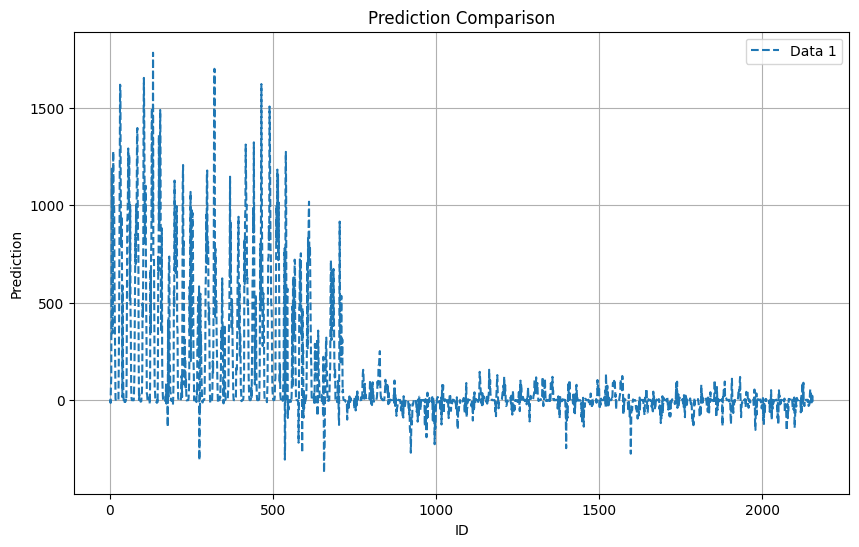

In [44]:
df1 = pd.read_csv("predictions_v16.csv")
df2 = pd.read_csv("pred_v54_blendedmodel.csv")

print(df1.columns)
print(df2.columns)

plt.figure(figsize=(10, 6))  # Set the size of the plot

plt.plot(df1['id'], df1['prediction'] - df2['prediction'], label='Data 1', linestyle='--')


plt.xlabel('ID')
plt.ylabel('Prediction')
plt.title('Prediction Comparison')
plt.legend()

plt.grid(True)
plt.show()







In [7]:

x_test_a = model1.preprocessing_X_test(X_test_estimated_a)
x_test_a.to_csv('proc_test_data_a.csv')

x_test_b = model1.preprocessing_X_test(X_test_estimated_b)
x_test_b.to_csv('proc_test_data_b.csv')


x_test_c = model1.preprocessing_X_test(X_test_estimated_c)
x_test_c.to_csv('proc_test_data_c.csv')

In [22]:

x_test_a = model_basic.add_estimated_flag(X_test_estimated_a, True)
x_test_a = model_basic.preprocessing_X_test(x_test_a)
x_test_a.to_csv('proc_test_data_a.csv')

x_test_b = model_basic.add_estimated_flag(X_test_estimated_b, True)
x_test_b = model_basic.preprocessing_X_test(x_test_b)
x_test_b.to_csv('proc_test_data_b.csv')

x_test_c = model_basic.add_estimated_flag(X_test_estimated_c, True)
x_test_c = model_basic.preprocessing_X_test(x_test_c)
x_test_c.to_csv('proc_test_data_c.csv')

h2o.init()
model_a1 = h2o.upload_model(model_a_observed)
#model = h2o.get_model(model_a)




est_test_a = h2o.H2OFrame(x_test_a)

preds_a1 = model_a1.predict(est_test_a)
preds_df_a1 = preds_a1.as_data_frame()



model_b1 = h2o.upload_model(model_b_observed)

#model = h2o.get_model(model_b)



est_test_b = h2o.H2OFrame(x_test_b)

preds_b1 = model_b1.predict(est_test_b)
preds_df_b1 = preds_b1.as_data_frame()


model_c1 = h2o.upload_model(model_c_observed)

#model = h2o.get_model(model_c)



est_test_c = h2o.H2OFrame(x_test_c)

preds_c1 = model_c1.predict(est_test_c)
preds_df_c1 = preds_c1.as_data_frame()






Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,6 mins 07 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_olelasson_w2nlvz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.399 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [23]:



# Calculate mean for group A
preds_df_a1.rename(columns={'predict': 'prediction'}, inplace=True)
preds_df_a1['prediction'] = preds_df_a1['prediction'].apply(lambda x: 0.0 if x < 20 else x)

# Calculate mean for group B
preds_df_b1.rename(columns={'predict': 'prediction'}, inplace=True)
preds_df_b1['prediction'] = preds_df_b1['prediction'].apply(lambda x: 0.0 if x < 20 else x)


# Calculate mean for group C
preds_df_c1.rename(columns={'predict': 'prediction'}, inplace=True)
preds_df_c1['prediction'] = preds_df_c1['prediction'].apply(lambda x: 0.0 if x < 20 else x)



# Combine DataFrames
final_df = pd.concat([preds_df_a1, preds_df_b1, preds_df_c1], axis=0, ignore_index=True)

# Set the index name to 'id'
final_df.index.name = 'id'

# Save to a CSV file
final_df.to_csv('pred_v59_fixedval.csv')


### Comperable prediction

In [17]:
file2 = 'predictions_v34_average_long&best_v32&16.csv'
file1 = 'pred_v59_fixedval.csv'

In [18]:
def create_comperable_prediction_csv(prediction_name):
    postproc_A = model_basic.preprocessing_X_test(X_test_estimated_a)
    postproc_B = model_basic.preprocessing_X_test(X_test_estimated_b)
    postproc_C = model_basic.preprocessing_X_test(X_test_estimated_c)

    postproc_A = postproc_A.reset_index()
    postproc_B = postproc_B.reset_index()
    postproc_C = postproc_C.reset_index()

    time_A = postproc_A['time']
    time_B = postproc_B['time']
    time_C = postproc_C['time']

    all_times = pd.concat([time_A, time_B, time_C], ignore_index=True)

    predictions = pd.read_csv(prediction_name)

    if len(all_times) == len(predictions):
        predictions['time'] = all_times
    else:
        raise ValueError("The concatenated 'time' column does not match the size of the predictions dataframe.")
    if 'id' in predictions.columns:
        predictions.drop(columns=['id'], axis=1, inplace=True)
    if ' id' in predictions.columns:
        predictions.drop(columns=[' id'], axis=1, inplace=True)
    

    predictions.to_csv(f'comperable_{prediction_name}')

create_comperable_prediction_csv(file1)
create_comperable_prediction_csv(file2)

In [19]:
# Load the CSV files
predictions_vX = pd.read_csv(f'comperable_{file1}')
predictions_vY = pd.read_csv(f'comperable_{file2}')


In [20]:
import seaborn as sns

# Convert the time column to datetime format for better plotting
predictions_vX['time'] = pd.to_datetime(predictions_vX['time'])
predictions_vY['time'] = pd.to_datetime(predictions_vY['time'])


# Extract day and hour information from the 'time' column
predictions_vY['day'] = predictions_vX['time'].dt.date
predictions_vX['hour'] = predictions_vX['time'].dt.hour

diff_vX_vY = (predictions_vX['prediction'] - predictions_vY['prediction']).abs()

# Compute the absolute difference for each timestamp
predictions_vX['diff'] = diff_vX_vY

third_length = len(predictions_vX) // 3

# Split the datasets for each location
locations = {
    "Location A": (0, third_length),
    "Location B": (third_length, 2 * third_length),
    "Location C": (2 * third_length, len(predictions_vX))
}

### Heatmap

In [51]:
# Plot heatmaps for each location
plt.figure(figsize=(15, 15))

for idx, (location, (start, end)) in enumerate(locations.items(), 1):
    # Pivot the data to get differences in a matrix form suitable for heatmap
    heatmap_data = predictions_vX[start:end].pivot("day", "hour", "diff")
    
    plt.subplot(3, 1, idx)
    sns.heatmap(heatmap_data, cmap="YlOrRd", cbar_kws={'label': 'Difference'})
    
    plt.title(f"Heatmap of Prediction Differences for {location}")
    plt.ylabel("Day")
    plt.xlabel("Hour of Day")

plt.tight_layout()
plt.show()

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

<Figure size 1500x1500 with 0 Axes>

### Diff Plot

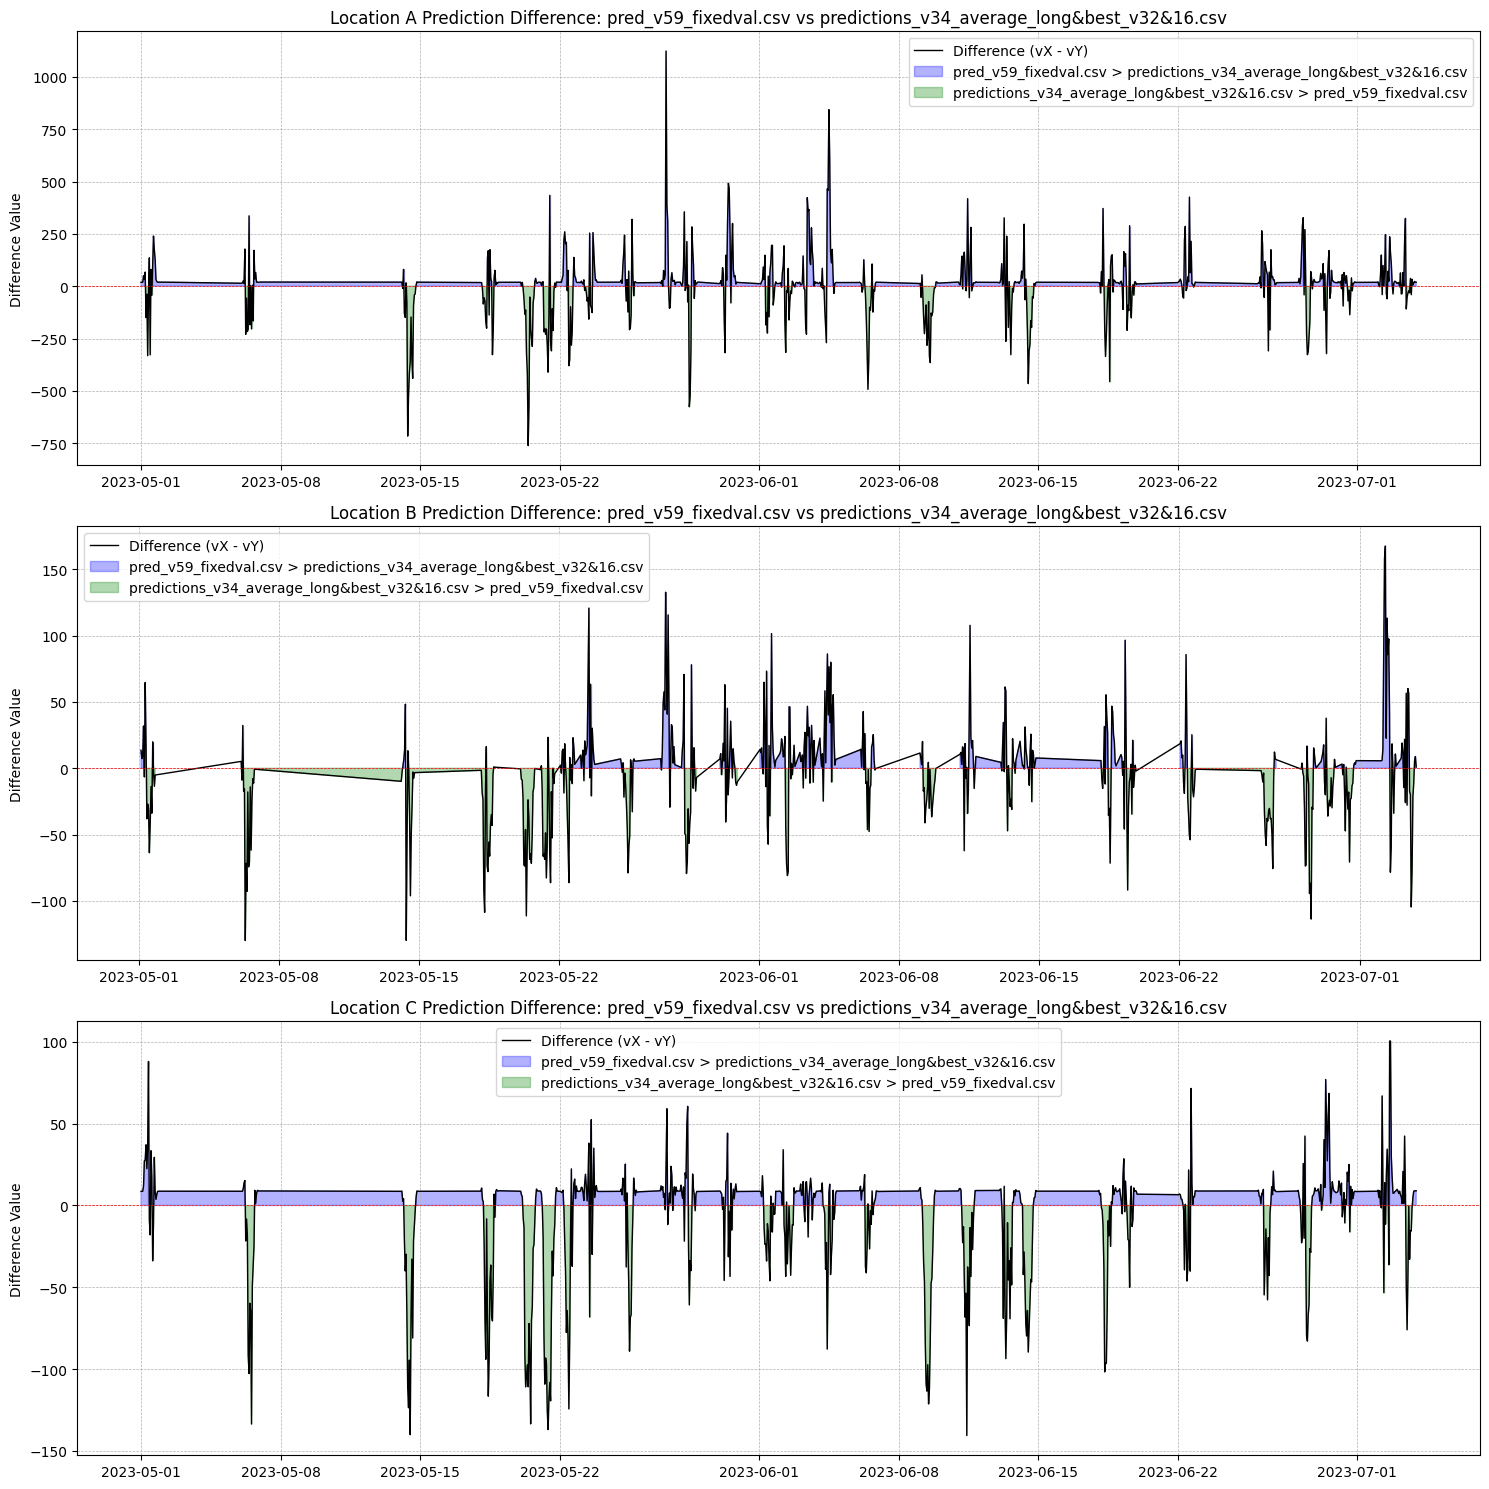

In [21]:
# Calculate the split index for each location based on the total number of rows
split_index = len(predictions_vX) // 3

# Split the datasets for each location
predictions_vX_A = predictions_vX.iloc[:split_index]
predictions_vX_B = predictions_vX.iloc[split_index:2*split_index]
predictions_vX_C = predictions_vX.iloc[2*split_index:]

predictions_vY_A = predictions_vY.iloc[:split_index]
predictions_vY_B = predictions_vY.iloc[split_index:2*split_index]
predictions_vY_C = predictions_vY.iloc[2*split_index:]

def filter_zero_intervals(df1, df2):
    """Filter out continuous zero intervals from both dataframes."""
    # Identify rows where both versions have zero predictions
    zero_mask = (df1['prediction'] == 0) & (df2['prediction'] == 0)
    
    # Filter out these rows
    return df1[~zero_mask], df2[~zero_mask]

def plot_difference(df1, df2, title):
    """Plot the difference between two dataframes' predictions."""
    diff = df1['prediction'] - df2['prediction']
    
    plt.plot(df1['time'], diff, label="Difference (vX - vY)", color="black", linewidth=1)
    
    # Highlight areas where Version X is greater than Version Y
    plt.fill_between(df1['time'], diff, where=(diff > 0), color='blue', alpha=0.3, label=f"{file1} > {file2}")
    
    # Highlight areas where Version Y is greater than Version X
    plt.fill_between(df1['time'], diff, where=(diff < 0), color='green', alpha=0.3, label=f"{file2} > {file1}")
    
    plt.axhline(0, color='red', linestyle="--", linewidth=0.5)
    plt.title(title)
    plt.ylabel("Difference Value")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Filter out zero intervals for each location
predictions_vX_A, predictions_vY_A = filter_zero_intervals(predictions_vX_A, predictions_vY_A)
predictions_vX_B, predictions_vY_B = filter_zero_intervals(predictions_vX_B, predictions_vY_B)
predictions_vX_C, predictions_vY_C = filter_zero_intervals(predictions_vX_C, predictions_vY_C)

predictions_vX_A.reset_index(inplace=True)
predictions_vY_A.reset_index(inplace=True)
predictions_vX_B.reset_index(inplace=True)
predictions_vY_B.reset_index(inplace=True)
predictions_vX_C.reset_index(inplace=True)
predictions_vY_C.reset_index(inplace=True)



# Set up the plots
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Plot the difference for each location
plt.sca(ax[0])
plot_difference(predictions_vX_A, predictions_vY_A, f"Location A Prediction Difference: {file1} vs {file2}")

plt.sca(ax[1])
plot_difference(predictions_vX_B, predictions_vY_B, f"Location B Prediction Difference: {file1} vs {file2}")

plt.sca(ax[2])
plot_difference(predictions_vX_C, predictions_vY_C, f"Location C Prediction Difference: {file1} vs {file2}")

plt.tight_layout()
plt.show()

In [8]:
data1 = pd.read_csv(file1)
data2 = pd.read_csv(file2)

final = pd.DataFrame()

final['prediction'] = (data1['prediction'] + data2['prediction']) / 2
final['prediction'] = final['prediction'].apply(lambda x: 0.0 if x < 5 else x)


final.index.name = 'id'

final.to_csv('predictions_v44_combo_v43&39.csv')


In [21]:
final = pd.read_csv('predictions_v38_summer.csv')

final['prediction'] = final['prediction'].apply(lambda x: 0.0 if x < 5 else x)

final.drop(columns='id', axis=1, inplace=True)

final.index.name = 'id'

final.to_csv('predictions_v39_summer&cut5.csv')

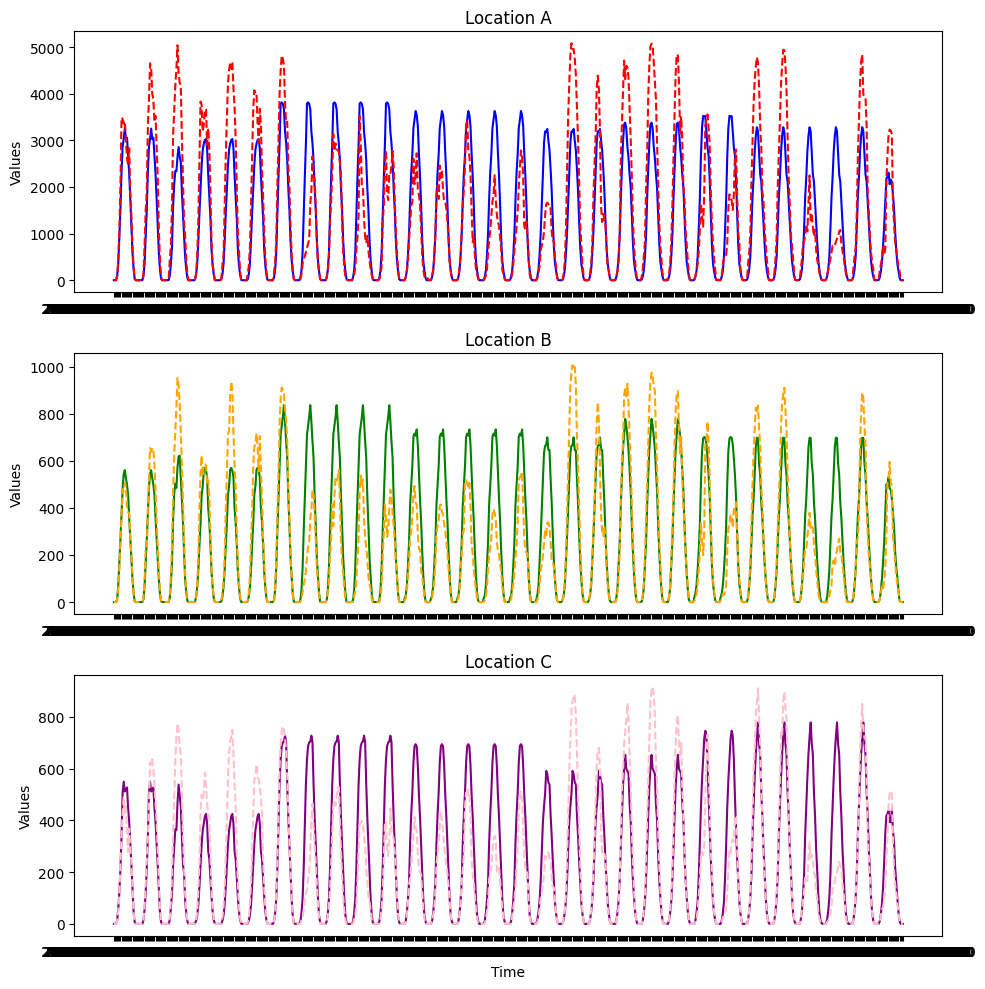

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate the split index for each location based on the total number of rows
split_index = len(predictions_vX) // 3

df = pd.read_csv('comperable_pred_v54_blendedmodel.csv')

a_data = pd.read_csv('proc_test_data_a.csv')
b_data = pd.read_csv('proc_test_data_b.csv')
c_data = pd.read_csv('proc_test_data_c.csv')

# Split the datasets for each location
a = df.iloc[:split_index]
b = df.iloc[split_index:2 * split_index]
c = df.iloc[2 * split_index:]

a_combined = a_data.merge(a, how='inner', on='time')
b_combined = b_data.merge(b, how='inner', on='time')
c_combined = c_data.merge(c, how='inner', on='time')

# Set up the figure and axes
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Customize the plot for location A
axs[0].plot(a_combined['time'], a_combined['average_measurement'], label='Actual A', linestyle='-', color='blue')
axs[0].plot(a_combined['time'], a_combined['prediction'], label='Prediction A', linestyle='--', color='red')
axs[0].set_ylabel('Values')
axs[0].set_title('Location A')


# Customize the plot for location B
axs[1].plot(b_combined['time'], b_combined['average_measurement'], label='Actual B', linestyle='-', color='green')
axs[1].plot(b_combined['time'], b_combined['prediction'], label='Prediction B', linestyle='--', color='orange')
axs[1].set_ylabel('Values')
axs[1].set_title('Location B')


# Customize the plot for location C
axs[2].plot(c_combined['time'], c_combined['average_measurement'], label='Actual C', linestyle='-', color='purple')
axs[2].plot(c_combined['time'], c_combined['prediction'], label='Prediction C', linestyle='--', color='pink')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Values')
axs[2].set_title('Location C')


# Show the plots
plt.tight_layout()



